# Telco Churn Prediction
This notebook uses a dataset from Telco detailing various data about its consumers, and ultimately whether they left for another provider or not. I use pandas to manipulate the data, and use sklearn to create a random forest classifier about whether a user will churn or not with about 80% accuracy. I then set the default threshold higher than normal to shift the model in favor of precision at the cost of recall, as there are limited resources to deal with customers likely to churn. Thus, taking a smaller sample of higher likelyhood churn customers is beneficial here.
## Dependencies
Link to Data:

Pandas

Numpy

Matplotlib

Seaborn

Scikit-Learn
## Author
Scott Little

Github: https://github.com/ScottMoffatLittle/TelcoChurnPrediction.git

Email: sml029@bucknell.edu

June 7, 2019

## Read In Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
df = pd.read_csv('./data_cust_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Format and Scale Data

In [3]:
#Drop Customer ID, does not correlate
df = df.drop('customerID', axis=1)

#Encode categorial variables
lbe = LabelEncoder()
cols_to_transform = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',\
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',\
                     'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'] 
for i in cols_to_transform:
    df[i] = lbe.fit_transform(df[i])

#substitute missing values in dataframe with nan
df = df.replace(r'^\s+$', np.nan, regex=True)

MEAN_CHARGE = 1000
#fill nan values in TotalCharges with 1000, about the average total charge
df['TotalCharges'] = df['TotalCharges'].fillna(MEAN_CHARGE)

#Scale total and monthly charges logorithmically to reign in outliers
df['MonthlyCharges'] = df['MonthlyCharges'].apply(np.log)
df['TotalCharges'] = df['TotalCharges'].astype(float).apply(np.log)

#Bin the most important features: TotalCharges and MonthlyCharges
labels = ["low", "low/med", "medium", "med/high", "high"]
df['TotBinned'] = pd.cut(df['TotalCharges'], bins=5, labels=labels)
df['MonBinned'] = pd.cut(df['TotalCharges'], bins=5, labels=labels)

#Apply One Hot Encoding to the binned columns
df = pd.get_dummies(df, columns=['TotBinned', 'MonBinned'])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TotBinned_low,TotBinned_low/med,TotBinned_medium,TotBinned_med/high,TotBinned_high,MonBinned_low,MonBinned_low/med,MonBinned_medium,MonBinned_med/high,MonBinned_high
0,0,0,1,0,1,0,1,0,0,2,...,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,34,1,0,0,2,0,...,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,2,1,0,0,2,2,...,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,45,0,1,0,2,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,2,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


## Create Benchmark

In [4]:
#Create random guess benchmark, based on overall churn rate of 0.2618
correct = 0
incorrect = 0
churn = 0
guess = 0
for index, row in df.iterrows():
    churn = int(row['Churn'])
    r = random.randint(0, 1)
    if r < 0.2618:
        guess = 0
    else:
        guess = 1
    if churn == guess:
        correct += 1
    else:
        incorrect += 1
print('accuracy: ' + str(correct / (correct + incorrect)))

accuracy: 0.5081641346017323


## Create Model

In [5]:
#Split the dataset into a train and test set
X = df.drop('Churn', axis=1)
Y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

In [6]:
#Random Forest Model - fit model and predict on test data

random_forest = RandomForestClassifier(n_estimators=100)
model = random_forest.fit(X_train, y_train)
y_model = random_forest.predict(X_test)


## Model Statistics

In [7]:
#Get accuracy of model
print('accuracy: ' + str(accuracy_score(y_test, y_model)))

accuracy: 0.8023850085178875


In [8]:
#Show the precision, recall, f1-score, and support of the model
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1327
           1       0.62      0.52      0.56       434

    accuracy                           0.80      1761
   macro avg       0.73      0.71      0.72      1761
weighted avg       0.79      0.80      0.80      1761



In [9]:
#Create graph of precision vs recall to help place the threshold in the correct spot to tune the model.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

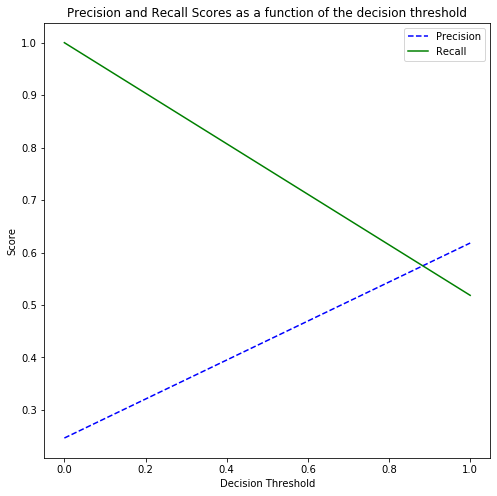

In [10]:
p, r, thresholds = precision_recall_curve(y_test, y_model)
plot_precision_recall_vs_threshold(p, r, thresholds)

## Improving The Model
Shift the default threshold right (to 0.58 from 0.5) so that the model is more precise, with lower recall. This means that on average, two thirds of selected customers would have churned, and 44 percent of total customers who will churn are selected

In [11]:
y_model = (model.predict_proba(X_test)[:,1] >= 0.58).astype(bool)
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1327
           1       0.64      0.43      0.51       434

    accuracy                           0.80      1761
   macro avg       0.74      0.67      0.69      1761
weighted avg       0.78      0.80      0.78      1761



## Model Analytics

In [12]:
# Accuracy of new model - slightly higher than the previous one
print('accuracy: ' + str(accuracy_score(y_test, y_model)))

accuracy: 0.7995457126632595


In [13]:
#Print the features that contributed to the model most, in order
#TotalCharges, MonthlyCharges were by far the largest contributors.
#This makes sense, because if people are paying a lot, they are likely to leave for a cheaper contract.
#Tenure as the third largest contributor makes sense as well as 
#If they have been with Teleco for a long time they are more likely to stay
features = list(df.columns.values)
importances = model.feature_importances_
feature_importances = dict(zip(features, importances))
sorted_features = sorted(feature_importances, key=feature_importances.get, reverse = True)
sorted_importances = sorted(importances, reverse=True)

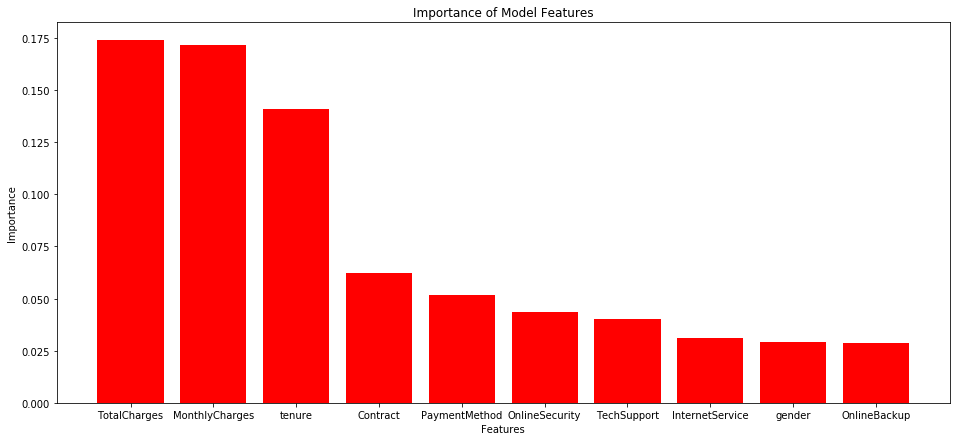

In [14]:
#Show the most important features graphically
x_pos = [i for i, _ in enumerate(sorted_features[:10])]

plt.figure(figsize=(16,7))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.bar(x_pos, sorted_importances[:10], color='red')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Importance of Model Features")
plt.xticks(x_pos, sorted_features[:10])

plt.show()

In [15]:
def churn_analysis_by_feature(crosstab):
    churn_percentages = []
    n_rows = len(crosstab.index)
    for row in range(n_rows):
        percent = crosstab[1][row]/ (crosstab[0][row] + crosstab[1][row])
        churn_percentages.append(percent)
    return churn_percentages


In [16]:
def show_feature_analysis(stats, labels, xlabel, ylabel, title):
    index = np.arange(len(stats))
    plt.bar(index, stats)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(index, labels, fontsize=12, rotation=30)
    plt.title(title)
    plt.show()

In [17]:
#Number of customers that churn based on level of total charges
test_df = df.copy()

test_df['TotalBinned'] = pd.cut(df['TotalCharges'], bins=5, labels=labels)
total_crosstab = pd.crosstab(test_df['TotalBinned'], test_df['Churn'])

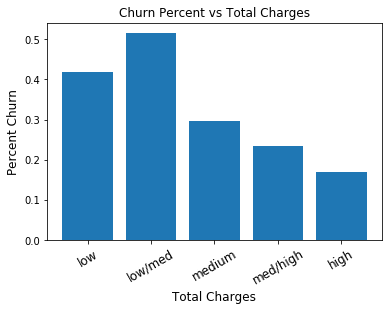

In [18]:
#Percentage of customers that churn based on level of total charges
percentages = churn_analysis_by_feature(total_crosstab)
show_feature_analysis(percentages, labels, 'Total Charges', 'Percent Churn', 'Churn Percent vs Total Charges' )


In [19]:
#Number of customers that churn based on level of monthly charges
test_df['MonthlyBinned'] = pd.cut(df['MonthlyCharges'], bins=5, labels=labels)
monthly_crosstab = pd.crosstab(test_df['MonthlyBinned'], test_df['Churn'])

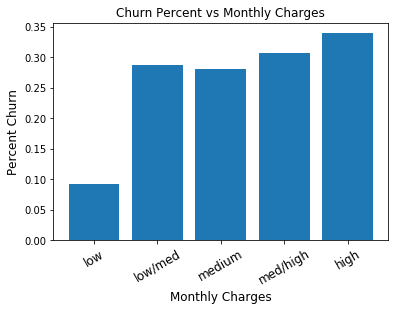

In [20]:
#Percentage of customers that churn based on level of monthly charges
percentages = churn_analysis_by_feature(monthly_crosstab)
show_feature_analysis(percentages, labels, 'Monthly Charges', 'Percent Churn', 'Churn Percent vs Monthly Charges' )

In [21]:
#Number of customers that churn based on the length of their tenure with Telco
test_df['TenureBinned'] = pd.cut(df['tenure'], bins=5, labels=labels)
tenure_crosstab = pd.crosstab(test_df['TenureBinned'], test_df['Churn'])

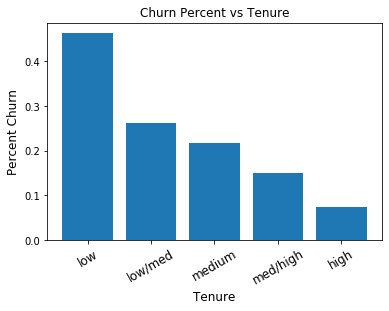

In [22]:
#Percentage of customers that churn based on the length of their tenure with Telco
percentages = churn_analysis_by_feature(tenure_crosstab)
show_feature_analysis(percentages, labels, 'Tenure', 'Percent Churn', 'Churn Percent vs Tenure' )

In [23]:
#Number of customers that churn based on their contract type
contract_crosstab = pd.crosstab(test_df['Contract'], test_df['Churn'])

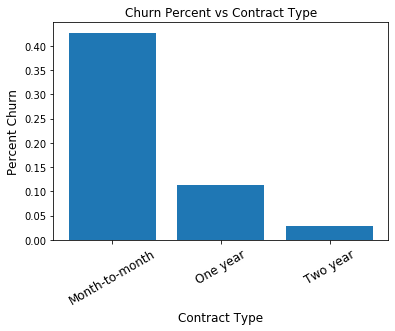

In [24]:
#Percentage of customers that churn based on their contract type
percentages = churn_analysis_by_feature(contract_crosstab)
contract_labels = ['Month-to-month', 'One year', 'Two year']
show_feature_analysis(percentages, contract_labels, 'Contract Type', 'Percent Churn', 'Churn Percent vs Contract Type' )

In [25]:
#Number of customers that churn based on their internet service type
internet_crosstab = pd.crosstab(test_df['InternetService'], test_df['Churn'])

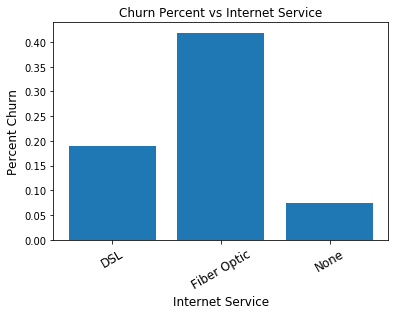

In [26]:
#Percentage of customers that churn based on their internet service type
percentages = churn_analysis_by_feature(internet_crosstab)
internet_labels = ['DSL', 'Fiber Optic', 'None']
show_feature_analysis(percentages, internet_labels, 'Internet Service', 'Percent Churn', 'Churn Percent vs Internet Service' )

In [27]:
#Number of customers that churn based on their payment method
pay_method_crosstab = pd.crosstab(test_df['PaymentMethod'], test_df['Churn'])

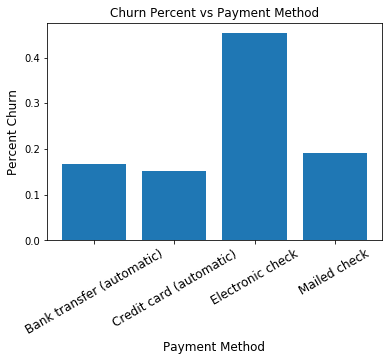

In [28]:
#Percent of customers that churn based on their payment method
percentages = churn_analysis_by_feature(pay_method_crosstab)
payment_labels = ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
show_feature_analysis(percentages, payment_labels, 'Payment Method', 'Percent Churn', 'Churn Percent vs Payment Method' )

In [29]:
#Number of customers that churn based on gender
gender_crosstab = pd.crosstab(df['gender'], df['Churn'])

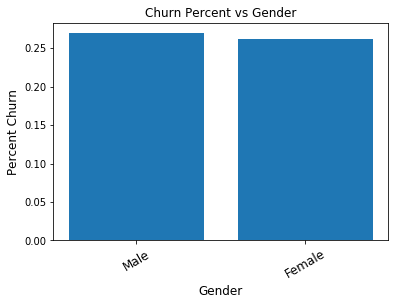

In [30]:
#percentage of customers that churn based on gender. Females Churn more than males
percentages = churn_analysis_by_feature(gender_crosstab)
genders = ['Male', 'Female']
show_feature_analysis(percentages, genders, 'Gender', 'Percent Churn', 'Churn Percent vs Gender' )